In [ ]:
import h5py
import numpy as np

with h5py.File("rgb_datasets.h5", "r") as hf:
    X_train_rgb = np.array(hf["X_train_rgb"])
    X_val_rgb = np.array(hf["X_val_rgb"])
    X_test_rgb = np.array(hf["X_test_rgb"])

print(f"Train Set Shape: {X_train_rgb.shape}")
print(f"Validation Set Shape: {X_val_rgb.shape}")
print(f"Test Set Shape: {X_test_rgb.shape}")


Train Set Shape: (12018, 299, 299, 3)
Validation Set Shape: (1502, 299, 299, 3)
Test Set Shape: (1503, 299, 299, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import numpy as np

2025-03-25 13:51:20.378429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-25 13:51:20.378463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-25 13:51:20.379425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 13:51:20.385222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-25 13:51:21.346486: W tensorflow/compiler/tf2

In [ ]:
def build_inception_resnetv2(input_shape=(299, 299, 3)):
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze pre-trained weights
    x = GlobalAveragePooling2D()(base_model.output)
    inception_output = Dense(512, activation='relu')(x)
    return Model(base_model.input, inception_output, name="InceptionResNetV2_FeatureExtractor")


In [ ]:
inception_model = build_inception_resnetv2()

2025-03-25 13:51:25.383111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-25 13:51:25.436686: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
inception_model.save("inception_model.keras")

In [ ]:
inception_model.summary()

Model: "InceptionResNetV2_FeatureExtractor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0      

In [ ]:
def predict_in_batches(model, X_data, batch_size=32):
    predictions = []
    for i in range(0, len(X_data), batch_size):
        batch = X_data[i:i+batch_size]
        pred = model.predict(batch)
        predictions.append(pred)
    return np.vstack(predictions)

X_train_inception = predict_in_batches(inception_model, X_train_rgb, batch_size=32)
X_val_inception = predict_in_batches(inception_model, X_val_rgb, batch_size=32)
X_test_inception = predict_in_batches(inception_model, X_test_rgb, batch_size=32)


1/1 [==============================] - 2s 2s/step


In [ ]:
import h5py

with h5py.File("inception_features.h5", "w") as f:
    f.create_dataset("X_train", data=X_train_inception)
    f.create_dataset("X_val", data=X_val_inception)
    f.create_dataset("X_test", data=X_test_inception)

print("Features saved in HDF5 format!")


Features saved in HDF5 format!


In [ ]:
with h5py.File("inception_features.h5", "r") as f:
    X_train_inception = f["X_train"][:]
    X_val_inception = f["X_val"][:]
    X_test_inception = f["X_test"][:]

print("Extracted features loaded from HDF5!")


Extracted features loaded from HDF5!


EVALUATION OF IRV2 EXTRACTED FEATURES

In [ ]:
print("Train Features Shape:", X_train_inception.shape)
print("Validation Features Shape:", X_val_inception.shape)
print("Test Features Shape:", X_test_inception.shape)

print("Feature Data Type:", X_train_inception.dtype)


Train Features Shape: (12018, 512)
Validation Features Shape: (1502, 512)
Test Features Shape: (1503, 512)
Feature Data Type: float32


In [ ]:
import numpy as np

print("First Feature Vector:\n", X_train_inception[5])

print("Min Value:", np.min(X_train_inception))
print("Max Value:", np.max(X_train_inception))


First Feature Vector:
 [1.0843081  0.11524246 0.5038084  0.7968579  0.68091136 0.8240516
 0.5271183  0.         0.03168187 0.1279621  0.13238943 0.
 1.1902063  0.4572405  0.         0.         0.         0.
 0.         0.70953906 0.         1.0463963  0.         0.611839
 0.75896686 0.         0.96231526 0.         0.         0.1451565
 0.18416211 0.18824655 0.         0.         0.         0.7691778
 0.18149868 0.         0.         0.6015388  0.7155564  0.
 0.7237197  0.         0.         0.         0.05148908 0.
 0.90764344 0.04071392 0.         0.07515052 0.         0.58663625
 0.16997783 0.         0.7466626  1.7178395  0.51635283 0.
 0.360271   0.         0.1720167  0.         0.         0.
 1.9722549  1.252457   0.05933075 0.         0.         0.
 0.         0.         0.58455265 0.         0.         0.
 0.         0.4771252  0.         0.7181741  0.         1.0584024
 0.         0.         0.         0.         0.         0.
 0.         1.5817964  1.3097718  0.         0.   

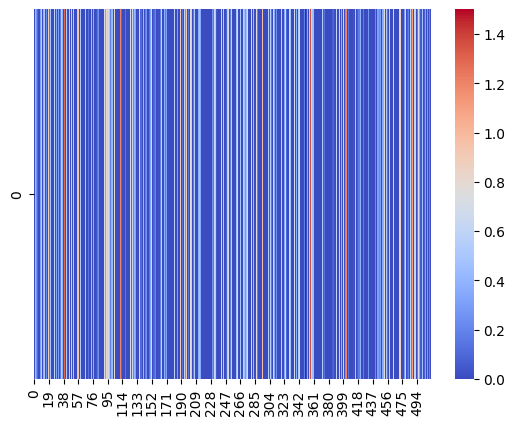

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

reshaped_features = np.expand_dims(X_train_inception[10], axis=0)
sns.heatmap(reshaped_features, cmap="coolwarm")
plt.show()


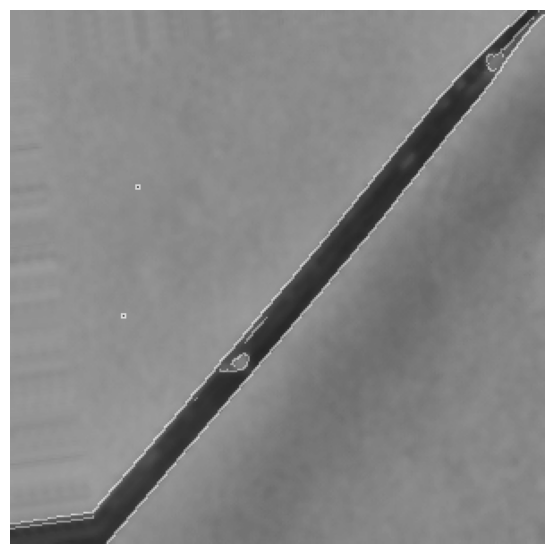

In [ ]:
import matplotlib.pyplot as plt

idx = np.random.choice(len(X_train_rgb), 1, replace=False)

plt.figure(figsize=(40, 20))
for i, index in enumerate(idx):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_rgb[index])
    plt.axis("off")
plt.show()
